In [4]:
import pandas as pd
import numpy as np
import os
import lxml.etree as et
import graphviz
from graphviz import Graph, Digraph
import networkx as nx
import matplotlib.pyplot as plt

In [5]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [6]:
class Node:
    def __init__(self, name):
        self.name = name
        self.children = []

In [7]:
def get_raw_entities(root_elem):
    name = root_elem.tag.split('}')[1]
    children = list(root_elem)
    if len(children) != 0:
        attrs = [c.tag.split('}')[1] for c in children]
        if name not in entities:
            entities[name] = attrs
        for c in children:
            get_raw_entities(c)

In [8]:
def get_entities_from_xml():
    get_raw_entities(root[0])
    result = {key:values for key, values in entities.items() if not (key[-1] == 's' and key[:-1] in values)}
    return result

In [9]:
def add_child(parent, child):
    parent.children.append(child)

def translate(entity_name, current_node):
    for attr in entities[entity_name]:
        new_node = Node(attr)
        add_child(current_node, new_node)
        if attr in entities:
            dot.edge(current_node.name, f'{attr}')
            translate(attr, new_node)
        else:
            dot.edge(current_node.name, f'{entity_name[0:3]}_{attr}') # add prefix to node for uniqueness

In [10]:
def graft(parents, node):
    for p in parents:
        for child in entities[node]:
            entities[p].append(child)
        entities[p].remove(node)

In [11]:
def prune(parent, node):
    entities[parent].remove(node)

#### Read and parse .xml

In [12]:
path = r'fcsNotificationEA44_0119300019817000426_12490609.xml'
tree = et.parse(path)
root = tree.getroot()
entities = {}
entities_names = []
entities = get_entities_from_xml()

#### Build an atribute tree

In [13]:
multiple = ['customerRequirements', 'kladrPlaces', 'purchaseObjects', 'preferenses', 'requirements', 'attachments']
for k,v in entities.items():
    entities[k] = list(map(lambda x: x[:-1] if x in multiple else x, v))
entities['applicationGuarantee'] = list(map(lambda x: x if x != 'procedureInfo' else 'info', entities['applicationGuarantee'])) 
entities['contractGuarantee'] = list(map(lambda x: x if x != 'procedureInfo' else 'info', entities['contractGuarantee'])) 
graft(['purchaseObject'], 'customerQuantities')
graft(['customerQuantity'], 'quantity')
graft(['reason'], 'responsibleDecision')
graft(['attachment'], 'cryptoSigns')
graft(['kladrPlace'], 'kladr')
graft(['fcsNotificationEF'], 'printForm')
prune('purchaseObject', 'quantity')
prune('currency', 'code')
prune('fcsNotificationEF', 'id')
prune('placingWay', 'code')
prune('preferense', 'code')
prune('ETP', 'code')
prune('kladrPlace', 'kladrCode')
prune('attachment', 'publishedContentId')
prune('customerRequirement', 'purchaseCode')
prune('customerRequirement', 'tenderPlanInfo')

In [14]:
root = Node('fcsNotificationEF')
#dot = Graph(comment='Atribute tree', strict=True, engine='fdp')
dot = Digraph(comment='Atribute tree', strict=True, engine='fdp')
dot.attr(size='25,5')
translate('fcsNotificationEF', root)
#dot.view() #to open .pdf

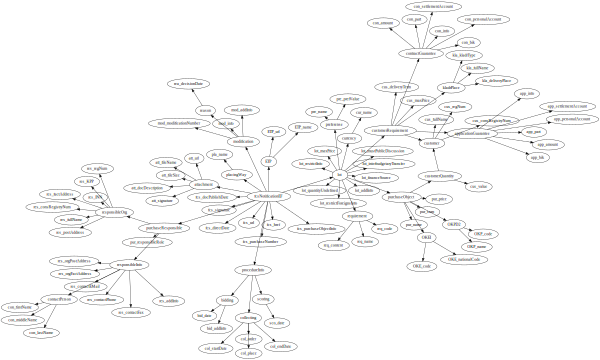

In [16]:
dot

### Define measures and dimensions from DFM.pdf

In [15]:
class DfmNode:
    def __init__(self, dimensions, measures=[]):
        self.measures = measures
        self.dimensions = dimensions
        self.distant_measures = []
        
    def merge_measures(self):
        self.measures.extend(self.distant_measures)
        self.measures = list(set(self.measures))

In [16]:
dfm = {
    'lot': DfmNode(['financeSource', 'mustPublicDiscussion', 'Currency', 'interbudgetaryTransfer'],
                   ['quntityUndefined', 'maxPrice']),
    'fcsNotificationEF': DfmNode(['placingWay', 'lot', 'ETP', 'procedureInfo', 'purchaseResponsible', 'docPublishDate',
                                  'directDate', 'modification_reasonType', 'modification_decisionDate']),
    'preference': DfmNode(['lot']),
    'requirement': DfmNode(['lot']),
    'purchaseObject': DfmNode(['OKDP2', 'OKEI', 'lot'], ['sum', 'price']),
    'customerQuantity': DfmNode(['purchaseObject', 'customer'], ['value']),
    'customerRequirement': DfmNode(['customer', 'lot', ], ['maxPrice']),
    'kladrPlace': DfmNode(['customerRequirement', 'kladrType']),
    'contractGuarantee': DfmNode(['customerRequirement'], ['amount']),
    'applicationGuarantee': DfmNode(['customerRequirement'], ['amount']),
    'purchaseResponsible': DfmNode(['responsibleRole', 'responsibleInfo', 'responsibleOrg']),
    'responsibleInfo': DfmNode(['contactPerson']),
    'attachment': DfmNode(['fcsNotificationEF'], ['fileSize']),
    'procedureInfo': DfmNode(['collecting_startDate', 'collecting_endDate', 'bidding_date', 'scoring_date']),
    'customer': DfmNode([]),
}

#### Add count/all measures

In [17]:
def add_previous(name):
    for dim in dfm[name].dimensions:
        if dim in dfm:
            dfm[name].distant_measures.extend([f'{name}/{m}' for m in dfm[dim].distant_measures])
            add_previous(dim)

In [18]:
measure_labels = ['_count'] # sum?
for label in measure_labels:
    for key, value in dfm.items():
        #dfm[key].distant_measures.append(key + label)
        dfm[key].distant_measures.extend([f'{key}/{dim}{label}' for dim in value.dimensions])
        add_previous(key)
        dfm[key].merge_measures()

In [19]:
dfm['customerQuantity'].measures

['customerQuantity/purchaseObject/lot/interbudgetaryTransfer_count',
 'customerQuantity/purchaseObject/lot/financeSource_count',
 'customerQuantity/purchaseObject/lot/mustPublicDiscussion_count',
 'customerQuantity/purchaseObject/lot/Currency_count',
 'customerQuantity/customer_count',
 'customerQuantity/purchaseObject_count',
 'customerQuantity/purchaseObject/OKDP2_count',
 'value',
 'customerQuantity/purchaseObject/lot_count',
 'customerQuantity/purchaseObject/OKEI_count']

In [20]:
dfm['purchaseObject'].measures

['purchaseObject/lot/Currency_count',
 'purchaseObject/lot_count',
 'price',
 'purchaseObject/lot/financeSource_count',
 'purchaseObject/OKDP2_count',
 'purchaseObject/lot/mustPublicDiscussion_count',
 'sum',
 'purchaseObject/OKEI_count',
 'purchaseObject/lot/interbudgetaryTransfer_count']

#### Create sets for the graph

In [21]:
#dimensions_set = set()
#for key, node in dfm.items():
    #dimensions_set |= set(node.dimensions)
dimensions_set = set(dfm.keys())

In [22]:
dimensions_set

{'applicationGuarantee',
 'attachment',
 'contractGuarantee',
 'customer',
 'customerQuantity',
 'customerRequirement',
 'fcsNotificationEF',
 'kladrPlace',
 'lot',
 'preference',
 'procedureInfo',
 'purchaseObject',
 'purchaseResponsible',
 'requirement',
 'responsibleInfo'}

In [23]:
measures_set = set()
for key, node in dfm.items():
    measures_set |= set(node.measures)
measures_set

{'amount',
 'applicationGuarantee/customerRequirement/customer_count',
 'applicationGuarantee/customerRequirement/lot/Currency_count',
 'applicationGuarantee/customerRequirement/lot/financeSource_count',
 'applicationGuarantee/customerRequirement/lot/interbudgetaryTransfer_count',
 'applicationGuarantee/customerRequirement/lot/mustPublicDiscussion_count',
 'applicationGuarantee/customerRequirement/lot_count',
 'applicationGuarantee/customerRequirement_count',
 'attachment/fcsNotificationEF/ETP_count',
 'attachment/fcsNotificationEF/directDate_count',
 'attachment/fcsNotificationEF/docPublishDate_count',
 'attachment/fcsNotificationEF/lot/Currency_count',
 'attachment/fcsNotificationEF/lot/financeSource_count',
 'attachment/fcsNotificationEF/lot/interbudgetaryTransfer_count',
 'attachment/fcsNotificationEF/lot/mustPublicDiscussion_count',
 'attachment/fcsNotificationEF/lot_count',
 'attachment/fcsNotificationEF/modification_decisionDate_count',
 'attachment/fcsNotificationEF/modificatio

In [24]:
print(len(dimensions_set))
print(len(measures_set))

15
100


### Create bipartite graph measures-dimensions

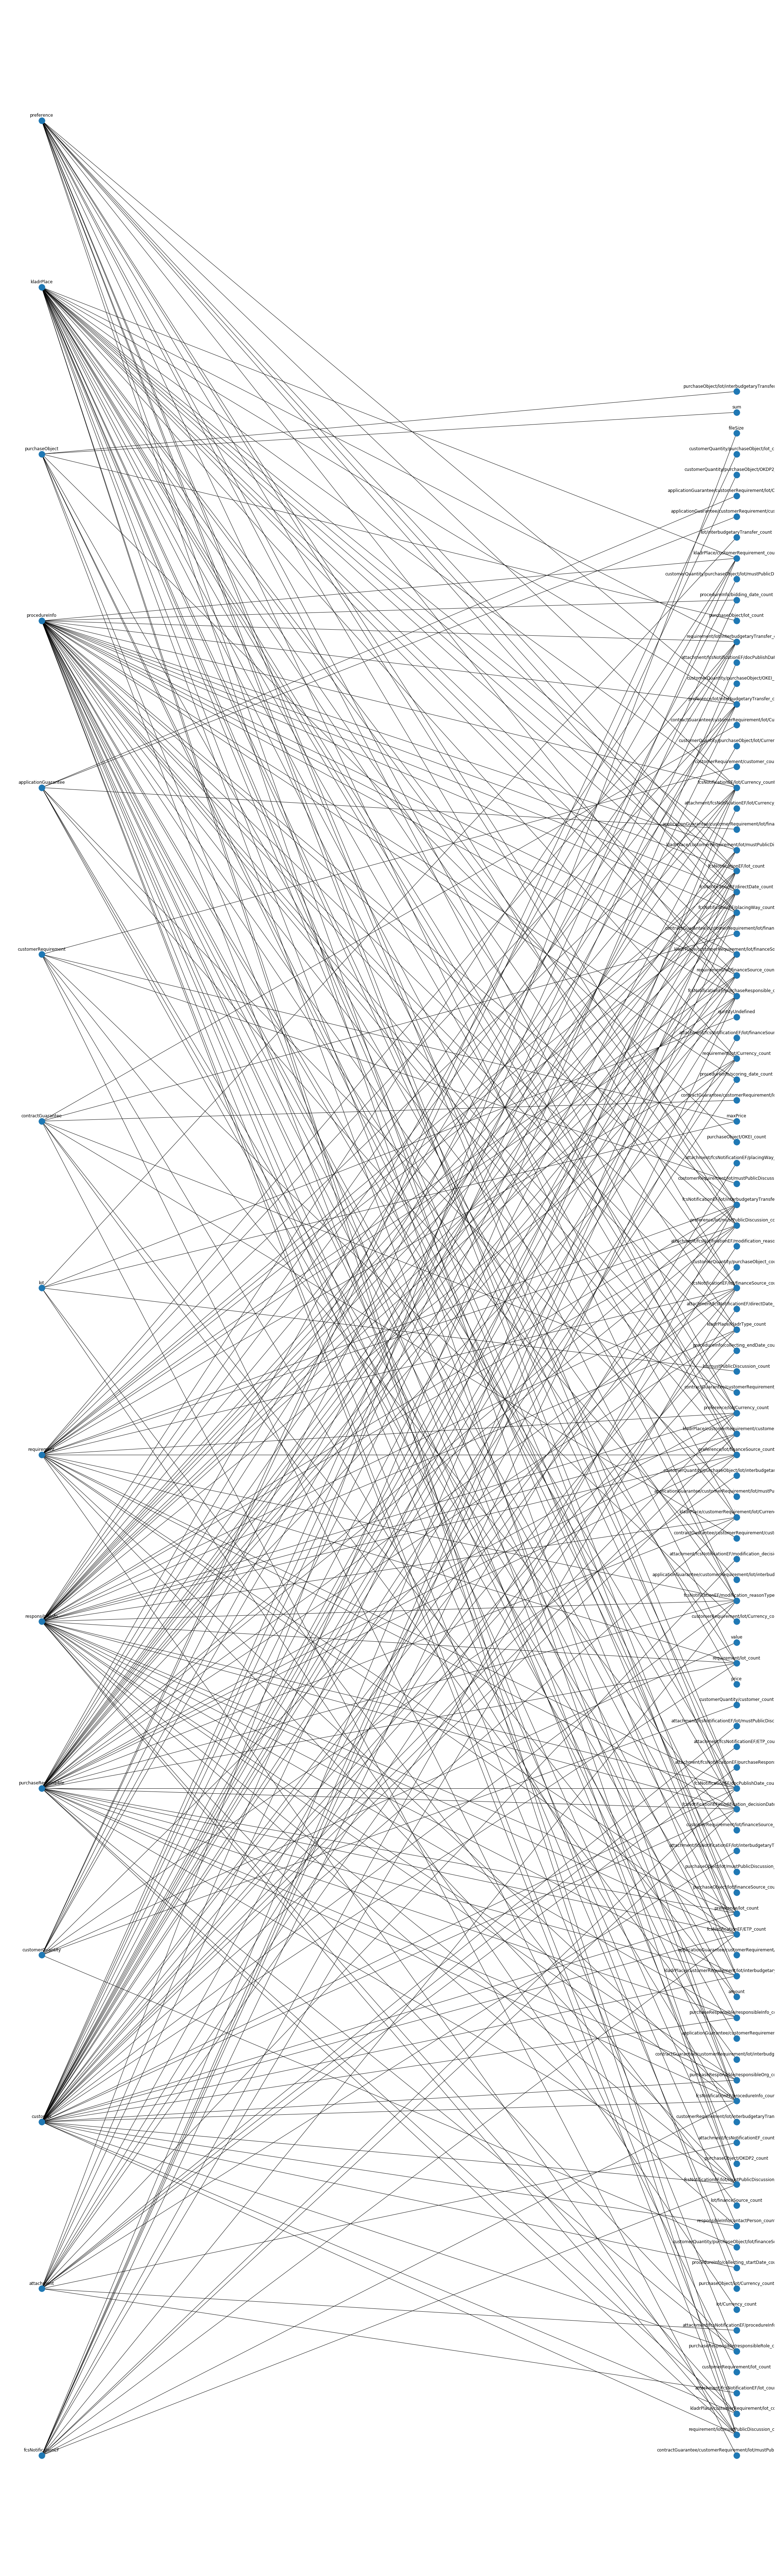

In [25]:
B = nx.Graph()
B.add_nodes_from(dimensions_set, bipartite=0) 
B.add_nodes_from(measures_set, bipartite=1)
edges = []
for key, node in dfm.items():
    for measure in node.measures:
        edges.append(
            (key, measure, 1)
        )
B.add_weighted_edges_from(edges, weight='weight')
 
#print(B.edges(data=True))
plt.figure(figsize=(30,100))
pos = {node:[0, i*16] for i, node in enumerate(dimensions_set)}
pos.update({node:[1, i*2] for i, node in enumerate(measures_set)})
nx.draw(B, pos, with_labels=False)
 
for p in pos:
    #pos[p][0] = pos[p][0] - 0.05 if pos[p][0] == 1 else pos[p][0]
    pos[p][1] += 0.5
nx.draw_networkx_labels(B, pos, color='r')

plt.show()

In [26]:
matrix = nx.algorithms.bipartite.matrix.biadjacency_matrix(B, list(dimensions_set))

In [27]:
matrix

<15x100 sparse matrix of type '<class 'numpy.int32'>'
	with 295 stored elements in Compressed Sparse Row format>

### An arbitrary query

In [30]:
import random

In [54]:
dimensions_list

['fcsNotificationEF',
 'attachment',
 'customer',
 'customerQuantity',
 'purchaseResponsible',
 'responsibleInfo',
 'requirement',
 'lot',
 'contractGuarantee',
 'customerRequirement',
 'applicationGuarantee',
 'procedureInfo',
 'purchaseObject',
 'kladrPlace',
 'preference']

In [108]:
def query_generator():
    query = []
    result = True
    start = random.choice(list(dimensions_set))
    query.append(start)
    path_length = random.randint(3, 7)

    while(path_length > 1):
        if dfm[start].dimensions and dimensions_set & set(dfm[start].dimensions):
            intersection = dimensions_set & set(dfm[start].dimensions)
            next_item = random.choice(list(intersection))
            query.append(next_item)
            start = next_item
        else:
            result = False
            break
        path_length -= 1
    if result:
        query.append(random.choice(dfm[start].measures))
        return query, result
    else:
        return query, result

In [111]:
first_try = query_generator()
while not first_try[1]:
    first_try = query_generator()
print(first_try[0])

['kladrPlace', 'customerRequirement', 'customer', 'fcsNotificationEF/placingWay_count']


In [113]:
dfm['customer'].measures

['kladrPlace/customerRequirement/customer_count',
 'preference/lot/financeSource_count',
 'procedureInfo/collecting_endDate_count',
 'preference/lot/Currency_count',
 'kladrPlace/kladrType_count',
 'requirement/lot/mustPublicDiscussion_count',
 'kladrPlace/customerRequirement/lot_count',
 'fcsNotificationEF/lot/financeSource_count',
 'preference/lot/mustPublicDiscussion_count',
 'fcsNotificationEF/lot/interbudgetaryTransfer_count',
 'purchaseResponsible/responsibleRole_count',
 'procedureInfo/collecting_startDate_count',
 'procedureInfo/scoring_date_count',
 'requirement/lot/Currency_count',
 'responsibleInfo/contactPerson_count',
 'fcsNotificationEF/purchaseResponsible_count',
 'fcsNotificationEF/lot/mustPublicDiscussion_count',
 'requirement/lot/financeSource_count',
 'kladrPlace/customerRequirement/lot/financeSource_count',
 'fcsNotificationEF/placingWay_count',
 'fcsNotificationEF/directDate_count',
 'fcsNotificationEF/procedureInfo_count',
 'fcsNotificationEF/lot_count',
 'kladrPl

In [ ]:
path = next(nx.all_simple_paths(B, source=0, target=5))